## Task 1
### Question
Briefly discuss why it is more difficult to find a good classifier on such a dataset than on one where, for example, 5,000 claims are fraudulent, and 5,000 are not. In particular, consider what happens when undetected fraudulent claims are very costly to the insurance company.

### Answer
When the dataset in highly unbalanced, like what in the car-insurance case, the machine learning algorithm can predict well in the majority class and predict poorly in minority class. Since most of machine learning algorithm always pursue to decrease error rate, thus they tend to predict the all the label to majority class one. In our scenario, the algorithm tends to predict all the claims non-fraudulent. However, the wrong prediction will increase the False-negative rate, which will increase the cost of fraudulent claims.
Another issue related to the scarce minority data is that we might miss some key combination of variables that has high probability to be fraudulent.

Check how much NaN values in each column when the claim is frandulent.
We can find when the claim is frandulent, most of the numerical variables are not missing, which means we could directly drop them.

In [2]:
import keras_tuner as kt

In [3]:
# TODO missing data 
# TODO draw the graph compare Fraud case
# TODO ANOVA
# check the range of all variables and drop unreasonable numbers
# split first and scale with smote code
# check scale first or smote first
# validation loss and trainning loss
# the batch size is 32
# TODO train test validation
# check the roc curve
# hidden layer number
# TODO smote oversampling issue(why the number is float)
# claim involved cover
# TODO clear session andv set seeds #FIXME
# TODO sensebility_at_spec
# TODO set seeds before 

# TO ASK
How to select the best model?

## Task 2

### TODO    
calculate the number of policyholdersnumber and vehicle number

### Question
Load the dataset "Insurance_claims.csv" and clean it as appropriate for use with machine learning algorithms. A description of the features can be found at the end of this document.

### Principle
1. Since the dataset is highly unbalanced, and the fraudulent dataset is very scarce, we don't want to drop the data label with 'fradulent'.
2. When the variables is categorical varibles, we tend to keep the Nah value as a classificaiton value rather than drop it.
3. When the variables is numerical variables, we will check how many NaN values is related to the fraudulent case. If few of them, we will drop the variable. Otherwise, we will find a way to fill in the NaN values.

### Proprocess procedure
1. load data and select useful columns
2. drop duplicates
3. drop unreasonable rows
4. deal with nan data
    - deal with the categorical nan data
    - deal with the numerical nan data
5. deal with date data
6. get an insight of the distribution of dataset
    - check whether there is a signicicant distribution difference in every column in fraud data and non-fraud data
    - TODO: plot categorical data
7. clean features
    - dummy
      - PolicyholderOccupation
      - ClaimCause
      - ClaimInvolvedCovers
      - DamageImportance
      - FirstPartyVehicleType 
      - ConnectionBetweenParties
      - PolicyWasSubscribedOnInternet
    - extract features in 'ClaimInvolvedCovers'
    - outlier # TODO
8. split data and scale
9.  show the data structure after preprocess



In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns',None)

## 2.1 Load data and select useful columns
We are going to use the following features to predict the fraud cases:
1. PolicyholderOccupation
2. LossDate
3. FirstPolicySubscriptionDate
4. ClainType
5. ClaimInvolvedCovers
6. DamageImportance
7. FirstPartyVehicleType
8. ConnectionBetweenParties
9. PolicyWasSubscribedOnInternet
10. NumberOfPoliciesOfPolicyholder
11. FpVehicleAgeMonths
12. EasinessToStage
13. ClaimWihoutIdentifiedThirdParty
14. ClaimAmount
15. LossHour
16. PolicyHolderAge
17. NumberOfBodilyInjuries
18. FirstPartyLiability
19. LossAndHolderPostCodeSame

And we also need label:
1. Fraud

In [5]:
# read data and get a brief idea of the data
df = pd.read_csv('./materials/Insurance_claims.csv')
# get useful features that needed in the machine learning model
# TODO using nlp to insurer notes data
needed_columns = [ 'PolicyholderOccupation',
       'LossDate', 'FirstPolicySubscriptionDate', 'ClaimCause',
       'ClaimInvolvedCovers', 'DamageImportance', 'FirstPartyVehicleType',
       'ConnectionBetweenParties', 'PolicyWasSubscribedOnInternet',
       'NumberOfPoliciesOfPolicyholder', 'FpVehicleAgeMonths',
       'EasinessToStage', 'ClaimWihoutIdentifiedThirdParty', 'ClaimAmount',
       'LossHour', 'PolicyHolderAge', 'NumberOfBodilyInjuries',
       'FirstPartyLiability', 'LossAndHolderPostCodeSame','Fraud']
df = df[needed_columns]

# show the first 5 rows, get some idea of the data structure
print(f'Data sample:')
print(df.head(5)) #TODO use sentiment analysis 
print('-----------------------------------------------------')

# get the columns name
print('Data Columns:')
print(str(df.columns))
print('-----------------------------------------------------')

# get some basic information about the data, and we found that the min number 
# of FpVehicleAgeMonths is less than 0, which does't make sense. We are going 
# to detect whether these rows are fraud cases or not. If they are all non-fraud,
# we can drop the rows with negative FpVehicleAgeMonths value. Otherwise, we will 
# create a new feature that record these abnormal rows since these unreasonable 
# values might be evidence of fraud cases.
print('Data description:')
print(df.describe())
print('-----------------------------------------------------')

# check whether there are any duplicated rows and we found there are 8 duplicated rows,
# which we are going to drop.
print('Data duplicated rows:')
print(df.duplicated().sum())
print('-----------------------------------------------------')

Data sample:
  PolicyholderOccupation  LossDate FirstPolicySubscriptionDate  \
0           CivilServant  02.01.19                    18.06.18   
1                 Worker  02.01.19                    29.06.17   
2                 Worker  02.01.19                    05.02.17   
3           CivilServant  02.01.19                    21.01.17   
4                 Farmer  02.01.19                    13.01.18   

                         ClaimCause  \
0               CollisionWithAnimal   
1                     LossOfControl   
2  AccidentWithIdentifiedThirdParty   
3  AccidentWithIdentifiedThirdParty   
4  AccidentWithIdentifiedThirdParty   

                               ClaimInvolvedCovers DamageImportance  \
0                     MaterialDamages ActLiability              NaN   
1                     MaterialDamages ActLiability              NaN   
2                     MaterialDamages ActLiability              NaN   
3  MaterialDamages ActLiability ReplacementVehicle              NaN   


## 2.2 Drop the duplicated rows

In [6]:
print('The shape of the data before dropping duplicated rows:')
df_shape_before_drop = df.shape
print(df.shape)
print('-----------------------------------------------------')

# drop the duplicated rows
df.drop_duplicates(inplace=True)

print('The shape of the data after dropping duplicated rows:')
df_shape_after_drop = df.shape
print(df.shape)
print('-----------------------------------------------------')

print(f'The number of rows that are dropped: {df_shape_before_drop[0]-df_shape_after_drop[0]}')



The shape of the data before dropping duplicated rows:
(11530, 20)
-----------------------------------------------------
The shape of the data after dropping duplicated rows:
(11516, 20)
-----------------------------------------------------
The number of rows that are dropped: 14


## 2.3 Drop unreasonable values


In [7]:
# check whether unreasonable rows contain fraud cases
df_unreasonable_rows = df[df['FpVehicleAgeMonths'] < 0]
df_shape_before_drop = df_unreasonable_rows.shape
print(df_unreasonable_rows)
print('-----------------------------------------------------')
# we can find that these three rows are not fraud cases. 
# Since we have enough non-fraud data, we can drop these rows.
df_shape_before_drop = df.shape
df.drop(df_unreasonable_rows.index, inplace=True)
df_shape_after_drop = df.shape

print(f'The number of rows that are dropped: {df_shape_before_drop[0]-df_shape_after_drop[0]}')

     PolicyholderOccupation  LossDate FirstPolicySubscriptionDate  \
8019                Retired  24.06.20                    22.10.19   
8446                Retired  21.07.20                    26.02.20   
8529                Retired  17.07.20                    26.02.20   

            ClaimCause           ClaimInvolvedCovers DamageImportance  \
8019     LossOfControl  MaterialDamages ActLiability              NaN   
8446     LossOfControl  MaterialDamages ActLiability              NaN   
8529  WindscreenDamage                    Windscreen              NaN   

     FirstPartyVehicleType ConnectionBetweenParties  \
8019                   Car                      NaN   
8446                   Car                      NaN   
8529                   Car                      NaN   

      PolicyWasSubscribedOnInternet  NumberOfPoliciesOfPolicyholder  \
8019                              0                               2   
8446                              0                               4

## 2.4 Deal with nan data
Check how much NaN values in each column.

We can find that except for 'FirstPartyVehicleNumber', 'ThirdPartyVehicleNumber', 'InsurerNotes', which we might not use in our models, most the NaN values are concentrated in the 'PolicyholderOccupation', 'ClaimCause',etc which are mainly categorical variables. In this case, we could turn these NaN values into a category value in order to take account the influence of missing variables, no mather what reason they are missing.

In terms of the numeric variables, we will furtherly check how many of them are missing when the claim is fraudulent or not. 

In [8]:
# Check how much NaN values in each column.
print(f'Number of NaN values in each column:') 
print(df.isnull().sum())

Number of NaN values in each column:
PolicyholderOccupation               340
LossDate                               0
FirstPolicySubscriptionDate            0
ClaimCause                           191
ClaimInvolvedCovers                  189
DamageImportance                   10775
FirstPartyVehicleType                 12
ConnectionBetweenParties           11415
PolicyWasSubscribedOnInternet          0
NumberOfPoliciesOfPolicyholder         0
FpVehicleAgeMonths                    12
EasinessToStage                        0
ClaimWihoutIdentifiedThirdParty        0
ClaimAmount                            0
LossHour                              94
PolicyHolderAge                       36
NumberOfBodilyInjuries                 0
FirstPartyLiability                    0
LossAndHolderPostCodeSame              0
Fraud                                  0
dtype: int64


We can find that in the Fraud case, there are a lot of data missing in categorical columns, but few in numerical columns.

Thus, we can set NaN as a category of categorical data and generate dummy variables. And we can drop the rows that contains NaN values in numerical columns.

In [9]:
# Check the number of missing data when Frand is True
df_fraud = df[df["Fraud"]==1]
print(f'Number of NaN values in each column when Frand is True:')
print(df_fraud.isnull().sum())

Number of NaN values in each column when Frand is True:
PolicyholderOccupation               4
LossDate                             0
FirstPolicySubscriptionDate          0
ClaimCause                           0
ClaimInvolvedCovers                  0
DamageImportance                    96
FirstPartyVehicleType                2
ConnectionBetweenParties           102
PolicyWasSubscribedOnInternet        0
NumberOfPoliciesOfPolicyholder       0
FpVehicleAgeMonths                   2
EasinessToStage                      0
ClaimWihoutIdentifiedThirdParty      0
ClaimAmount                          0
LossHour                             1
PolicyHolderAge                      0
NumberOfBodilyInjuries               0
FirstPartyLiability                  0
LossAndHolderPostCodeSame            0
Fraud                                0
dtype: int64


In [10]:
df_non_frand = df[df["Fraud"]==0]
print(f'Number of NaN values in each column when Frand is False:')
print(df_non_frand.isnull().sum())

Number of NaN values in each column when Frand is False:
PolicyholderOccupation               336
LossDate                               0
FirstPolicySubscriptionDate            0
ClaimCause                           191
ClaimInvolvedCovers                  189
DamageImportance                   10679
FirstPartyVehicleType                 10
ConnectionBetweenParties           11313
PolicyWasSubscribedOnInternet          0
NumberOfPoliciesOfPolicyholder         0
FpVehicleAgeMonths                    10
EasinessToStage                        0
ClaimWihoutIdentifiedThirdParty        0
ClaimAmount                            0
LossHour                              93
PolicyHolderAge                       36
NumberOfBodilyInjuries                 0
FirstPartyLiability                    0
LossAndHolderPostCodeSame              0
Fraud                                  0
dtype: int64


Fill the missing data in categorical columns with string NaN and make it a category

In [11]:
dummy_columns = ['PolicyholderOccupation', 'ClaimCause','ClaimInvolvedCovers', 'DamageImportance', 'FirstPartyVehicleType','ConnectionBetweenParties', 'PolicyWasSubscribedOnInternet']
df[dummy_columns] = df[dummy_columns].fillna('NaN')

Drop the missing data in numerical columns

In [12]:
df_shape_before_drop = df.shape
df_fraud_shape_before_drop = df[df["Fraud"]==1].shape
df.dropna(subset=["LossHour","PolicyHolderAge","FpVehicleAgeMonths"],inplace=True)
df_shape_after_drop = df.shape
df_fraud_shape_after_drop = df[df["Fraud"]==1].shape
print(f'The number of rows that are dropped: {df_shape_before_drop[0]-df_shape_after_drop[0]}')
print(f'The number of rows that are dropped when Frand is True: {df_fraud_shape_before_drop[0]-df_fraud_shape_after_drop[0]}')

The number of rows that are dropped: 142
The number of rows that are dropped when Frand is True: 3


After these steps, we don't have any missing data.

In [13]:
print('The number of NaN values in each column:')
df.isna().sum()
print('-----------------------------------------------------')

print('The shape of final datasets:')
print(df.shape)
print('-----------------------------------------------------')

print("Data sample:")
print(df.head(5))
print('-----------------------------------------------------')

The number of NaN values in each column:
-----------------------------------------------------
The shape of final datasets:
(11371, 20)
-----------------------------------------------------
Data sample:
  PolicyholderOccupation  LossDate FirstPolicySubscriptionDate  \
0           CivilServant  02.01.19                    18.06.18   
1                 Worker  02.01.19                    29.06.17   
2                 Worker  02.01.19                    05.02.17   
3           CivilServant  02.01.19                    21.01.17   
4                 Farmer  02.01.19                    13.01.18   

                         ClaimCause  \
0               CollisionWithAnimal   
1                     LossOfControl   
2  AccidentWithIdentifiedThirdParty   
3  AccidentWithIdentifiedThirdParty   
4  AccidentWithIdentifiedThirdParty   

                               ClaimInvolvedCovers DamageImportance  \
0                     MaterialDamages ActLiability              NaN   
1                     M

## 2.5 Deal with date data
We tend to consider the date data as important features. Because we consider that in different time period, people might have different tendency to defraud. And this argument is supported by Pascal Blanque(2002), who asserted that the economic crisis is an important reason for the defraud.

However, our date data is datetime format, which cannot be used in machine learning model. In hence, we will convert the date data into timestamp.

In [14]:
# turn the date into timestamp
df['LossDate'] = df['LossDate'].apply(lambda x:datetime.datetime.strptime(x,'%d.%M.%y').timestamp())
df['FirstPolicySubscriptionDate'] = df['FirstPolicySubscriptionDate'].apply(lambda x:datetime.datetime.strptime(x,'%d.%M.%y').timestamp())


## 2.6 Get an insight of the distribution of dataset

According to the distribution of the numerical data, we can see that there are some diffenece between the fraud and non-fraud cases, especially in the distribution of 'FpVehicleAgeMonths' and 'claimAmount'. In the fraud cases, they usually have a more disperse distribution in 'FpVehicleAgeMonths' and higher value in 'claimAmount'. 

And in the categorical data, we can find some interesting patterns. For example, in the fraud cases, the percentage of 'TotalLoss' is much higher than the non-fraud cases, which is understandable. And in the fraud cases, the fraud cases tend to be same address between two parties.

In [15]:
# get the datasets that are fraud cases and non-fraud cases
df_fraud = df[df['Fraud'] == 1]
df_non_fraud = df[df['Fraud'] == 0]

In [16]:
# get the mean of both datasets
print('The mean of fraud datasets:')
print('-----------------------------------------------------')
df_fraud_mean = df_fraud.mean()
print(df_fraud_mean)
print('-----------------------------------------------------')

print('The mean of non-fraud datasets:')
print('-----------------------------------------------------')
df_non_fraud_mean = df_non_fraud.mean()
print(df_non_fraud_mean)
print('-----------------------------------------------------')

The mean of fraud datasets:
-----------------------------------------------------
LossDate                           1.557971e+09
FirstPolicySubscriptionDate        1.546519e+09
PolicyWasSubscribedOnInternet      2.857143e-01
NumberOfPoliciesOfPolicyholder     1.625000e+00
FpVehicleAgeMonths                 1.177143e+02
EasinessToStage                    3.464286e-01
ClaimWihoutIdentifiedThirdParty    5.625000e-01
ClaimAmount                        3.647878e+03
LossHour                           1.292857e+01
PolicyHolderAge                    4.104464e+01
NumberOfBodilyInjuries             3.571429e-02
FirstPartyLiability                4.910714e-01
LossAndHolderPostCodeSame          6.160714e-01
Fraud                              1.000000e+00
dtype: float64
-----------------------------------------------------
The mean of non-fraud datasets:
-----------------------------------------------------
LossDate                           1.564733e+09
FirstPolicySubscriptionDate        1.523620

/var/folders/3d/_kfrpmln4vl2vz6_7j1h6byh0000gn/T/ipykernel_78650/1158699191.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_fraud_mean = df_fraud.mean()
/var/folders/3d/_kfrpmln4vl2vz6_7j1h6byh0000gn/T/ipykernel_78650/1158699191.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_non_fraud_mean = df_non_fraud.mean()


The distribution numerical data of fraud datasets:


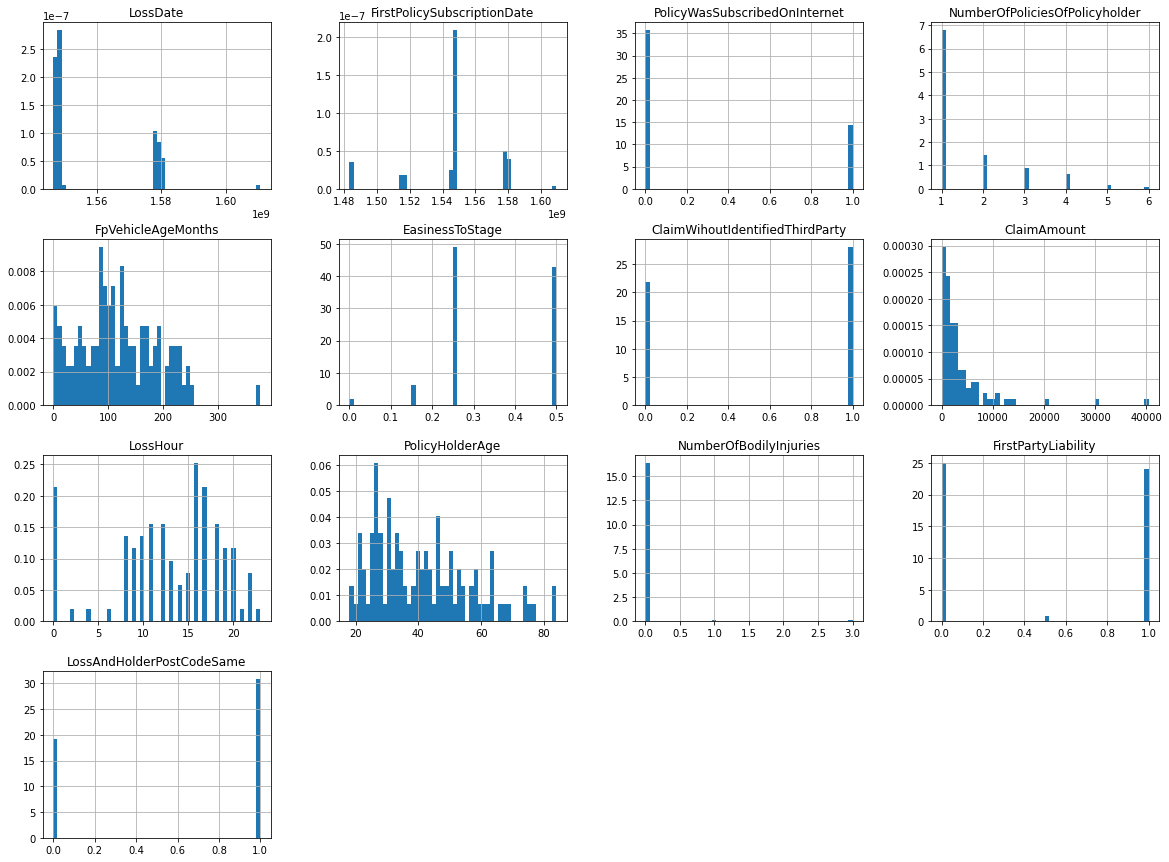

-----------------------------------------------------
The distribution numerical data of non-fraud datasets:


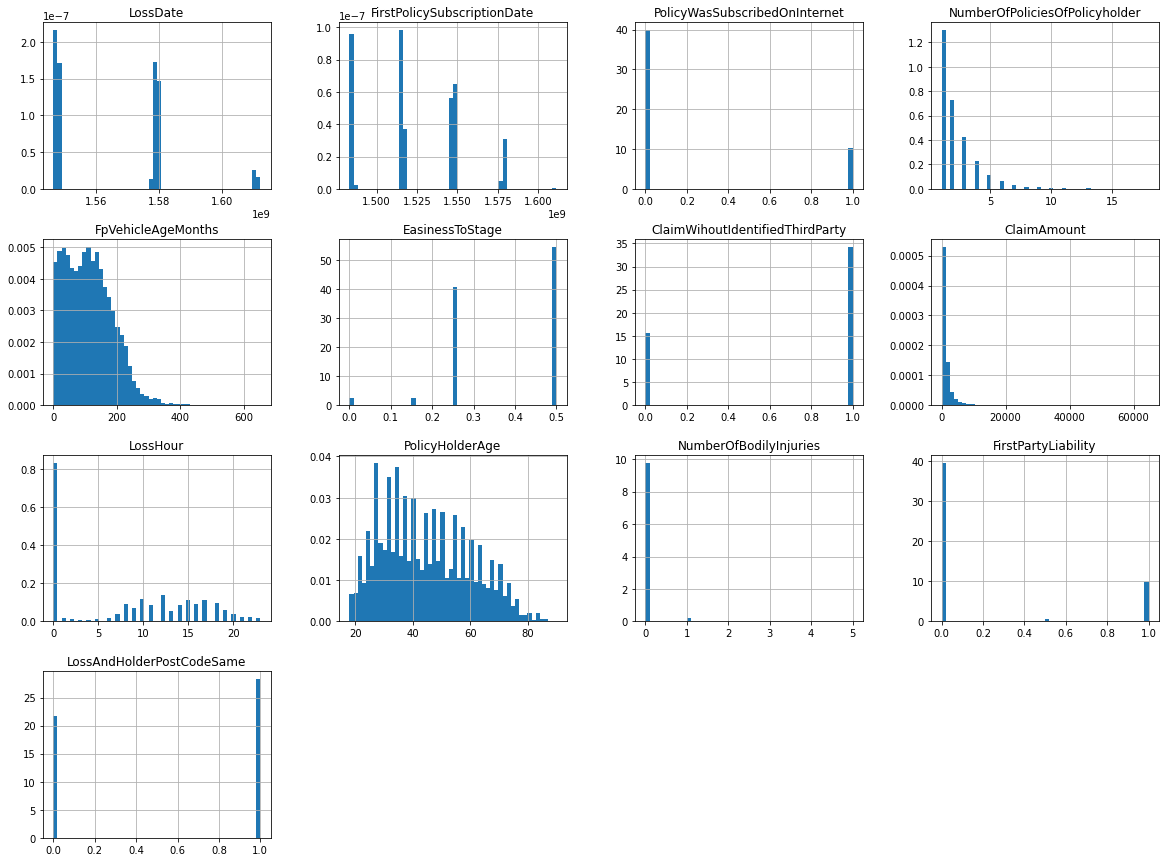

In [17]:
# plot the distribution of fraud datasets
print('The distribution numerical data of fraud datasets:')
df_fraud.iloc[:,:-1].hist(bins=50, figsize=(20,15),density=True, xlabelsize=10, ylabelsize=10) #TODO add title
plt.show()
print('-----------------------------------------------------')

# plot the distribution of non-fraud datasets
print('The distribution numerical data of non-fraud datasets:')
df_non_fraud.iloc[:,:-1].hist(bins=50, figsize=(20,15),density=True, xlabelsize=10, ylabelsize=10)
plt.show()

# TODO show the classification of categorical data


<Figure size 1440x1440 with 0 Axes>

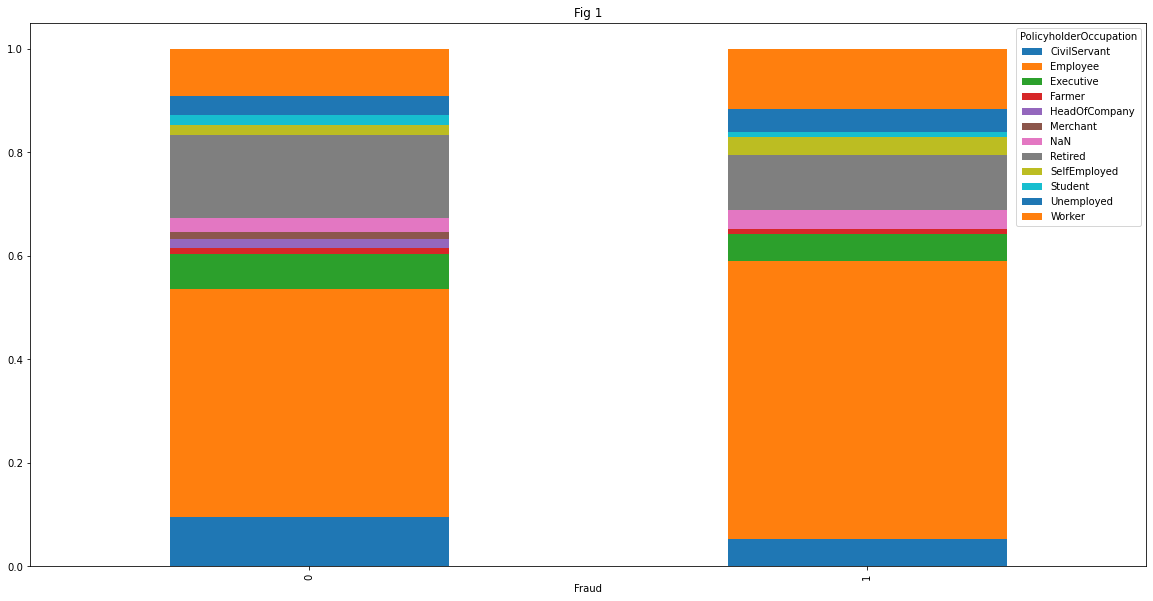

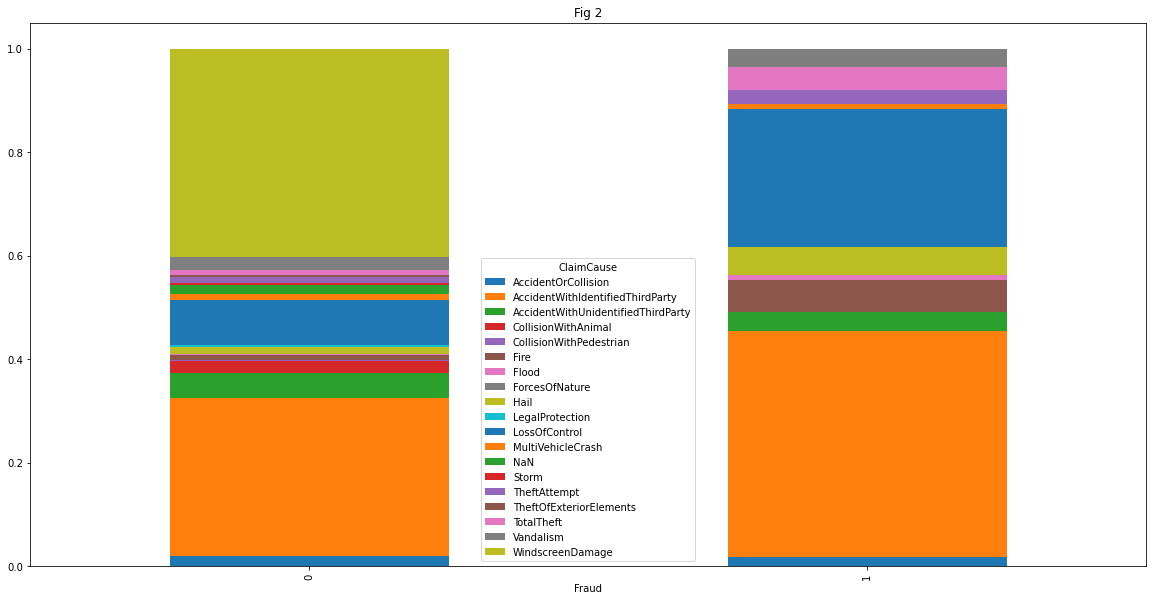

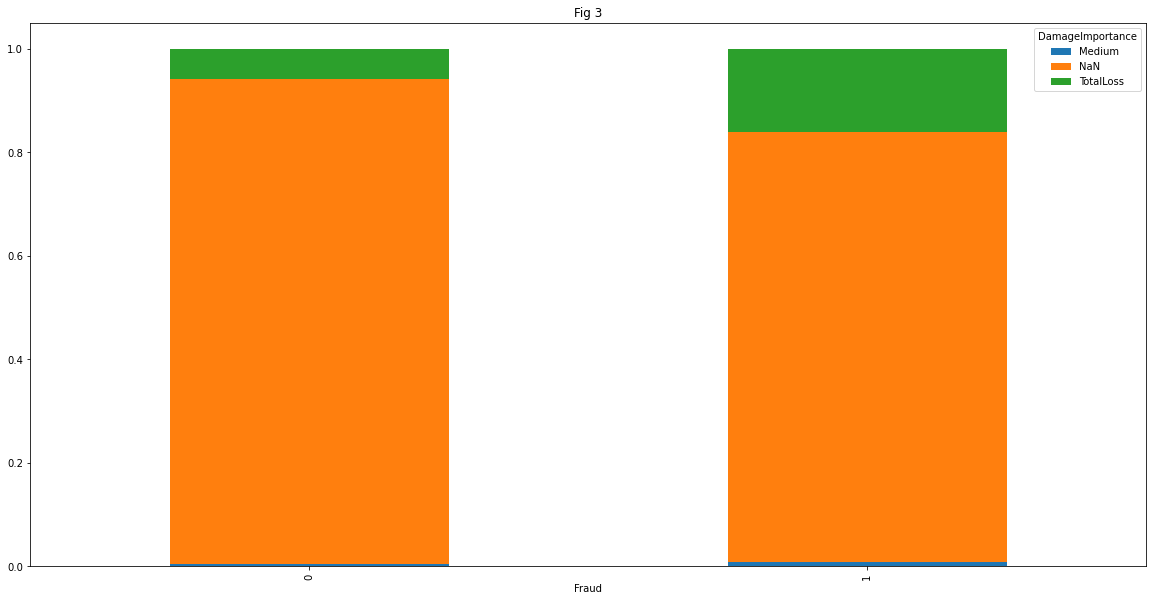

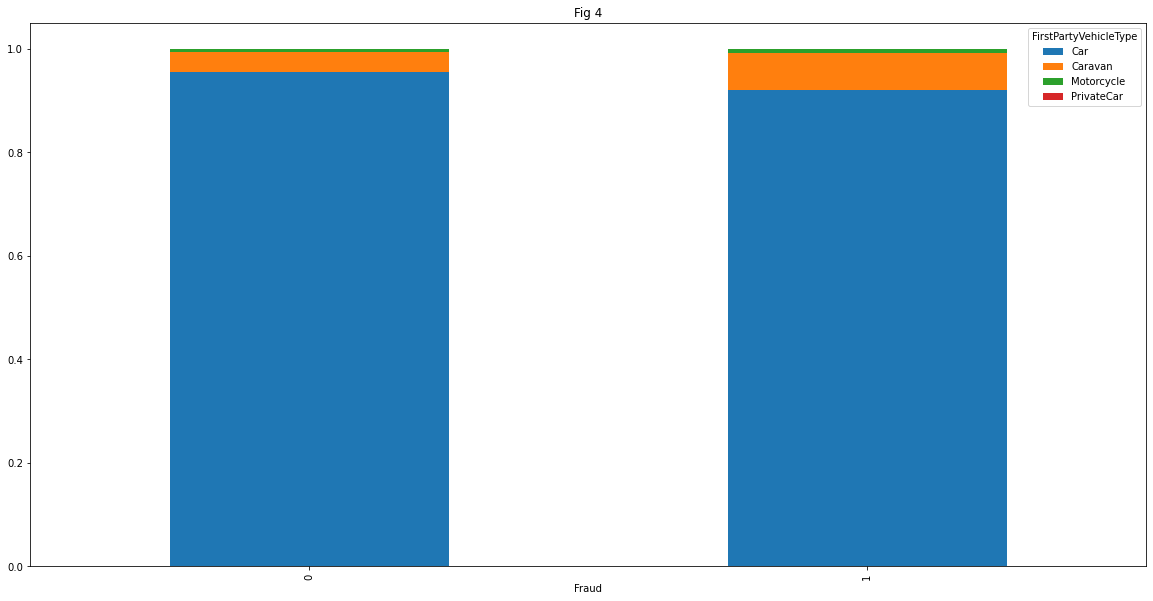

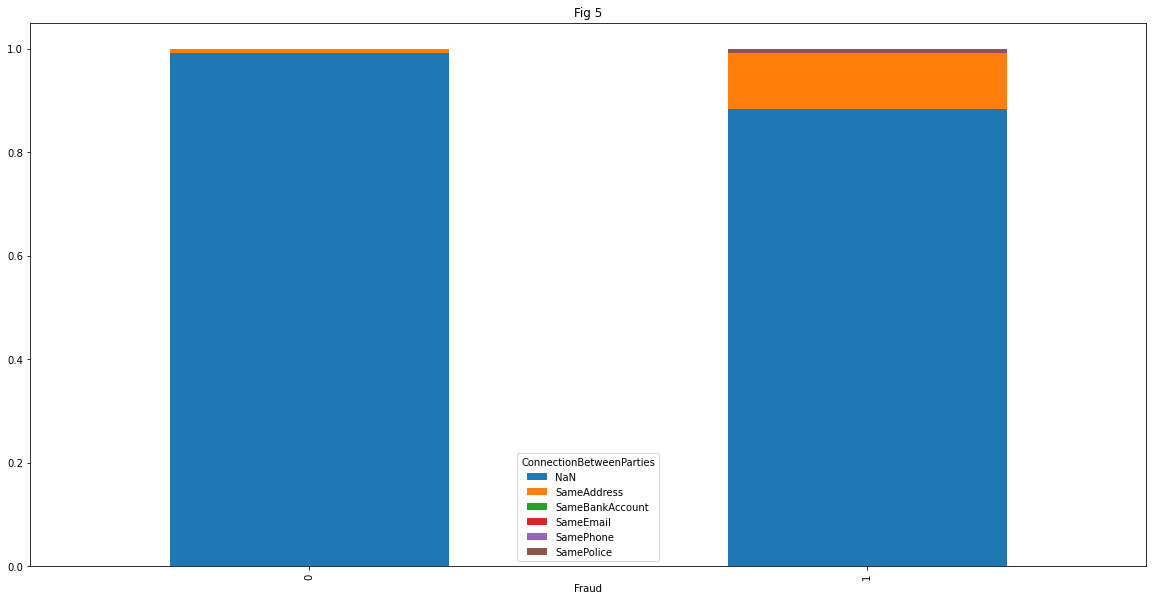

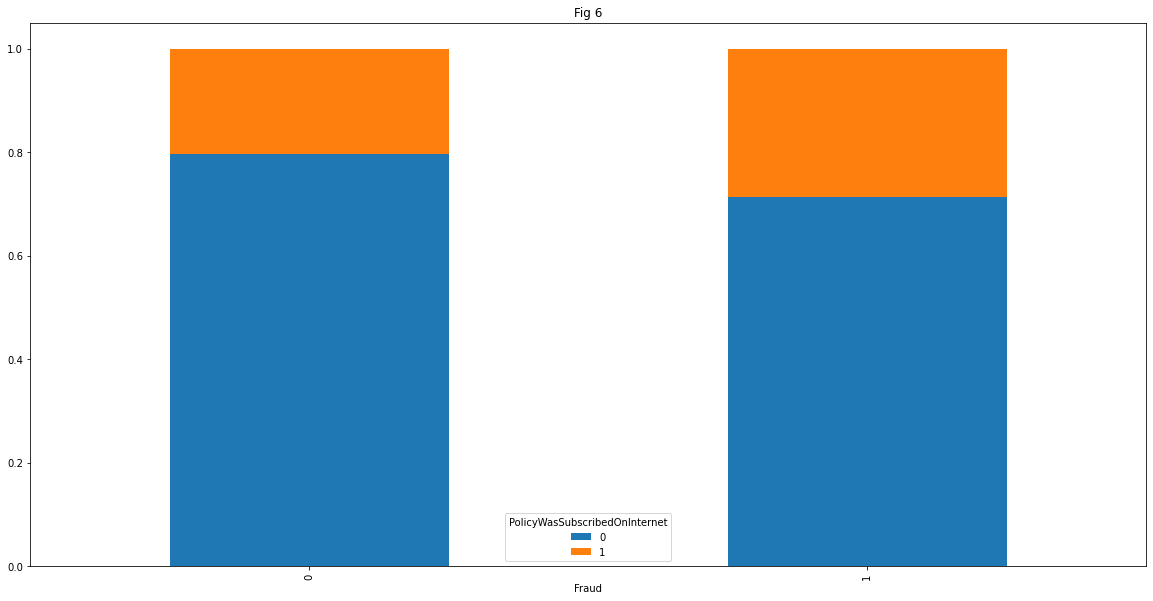

In [18]:
dummy_columns = ['PolicyholderOccupation', 'ClaimCause', 'DamageImportance', 'FirstPartyVehicleType','ConnectionBetweenParties', 'PolicyWasSubscribedOnInternet']

fig = plt.figure(figsize=(20,20))

names = locals()
for i, col in enumerate(dummy_columns):
    names[f"ax_{i}"] = df.groupby(['Fraud'])[col].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, figsize=(20,10),title=f"Fig {i+1}")

## 2.7 Clean features
1. deal with outliers 
    The presence of outliers in the data is a major problem for machine learning algorithms (Chakravarty, et al., 2020). 
    TODO: deal with outliers, or at the end to illustrate the lackness of the research
   
     
2. dummy variables

In [19]:
# Get dummy variables for categorical data
dummy_columns = ['PolicyholderOccupation', 'ClaimCause', 'DamageImportance', 'FirstPartyVehicleType','ConnectionBetweenParties', 'PolicyWasSubscribedOnInternet']
# Dummy variables for categorical data
df = pd.get_dummies(df,columns=dummy_columns,drop_first=True)
df


,LossDate,FirstPolicySubscriptionDate,ClaimInvolvedCovers,NumberOfPoliciesOfPolicyholder,FpVehicleAgeMonths,EasinessToStage,ClaimWihoutIdentifiedThirdParty,ClaimAmount,LossHour,PolicyHolderAge,NumberOfBodilyInjuries,FirstPartyLiability,LossAndHolderPostCodeSame,Fraud,PolicyholderOccupation_Employee,PolicyholderOccupation_Executive,PolicyholderOccupation_Farmer,PolicyholderOccupation_HeadOfCompany,PolicyholderOccupation_Merchant,PolicyholderOccupation_NaN,PolicyholderOccupation_Retired,PolicyholderOccupation_SelfEmployed,PolicyholderOccupation_Student,PolicyholderOccupation_Unemployed,PolicyholderOccupation_Worker,ClaimCause_AccidentWithIdentifiedThirdParty,ClaimCause_AccidentWithUnidentifiedThirdParty,ClaimCause_CollisionWithAnimal,ClaimCause_CollisionWithPedestrian,ClaimCause_Fire,ClaimCause_Flood,ClaimCause_ForcesOfNature,ClaimCause_Hail,ClaimCause_LegalProtection,ClaimCause_LossOfControl,ClaimCause_MultiVehicleCrash,ClaimCause_NaN,ClaimCause_Storm,ClaimCause_TheftAttempt,ClaimCause_TheftOfExteriorElements,ClaimCause_TotalTheft,ClaimCause_Vandalism,ClaimCause_WindscreenDamage,DamageImportance_NaN,DamageImportance_TotalLoss,FirstPartyVehicleType_Caravan,FirstPartyVehicleType_Motorcycle,FirstPartyVehicleType_PrivateCar,ConnectionBetweenParties_SameAddress,ConnectionBetweenParties_SameBankAccount,ConnectionBetweenParties_SameEmail,ConnectionBetweenParties_SamePhone,ConnectionBetweenParties_SamePolice,PolicyWasSubscribedOnInternet_1
0,1.546387e+09,1.516234e+09,MaterialDamages ActLiability,1,104.0,0.25,1,4624.73,8.0,45.0,0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,1.546387e+09,1.485648e+09,MaterialDamages ActLiability,3,230.0,0.50,1,1606.81,11.0,20.0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,1.546387e+09,1.483575e+09,MaterialDamages ActLiability,9,93.0,0.25,0,998.20,18.0,32.0,0,0.5,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,1.546387e+09,1.484957e+09,MaterialDamages ActLiability ReplacementVehicle,2,56.0,0.25,0,2506.92,11.0,46.0,0,0.5,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,1.546387e+09,1.515802e+09,ActLiability,4,110.0,0.25,0,12.00,12.0,28.0,0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11525,1.610842e+09,1.547511e+09,Windscreen,1,85.0,0.50,1,1010.23,0.0,56.0,0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
11526,1.609978e+09,1.484871e+09,Windscreen,3,119.0,0.50,1,154.35,0.0,54.0,0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
11527,1.610669e+09,1.580343e+09,Windscreen,4,139.0,0.50,1,420.25,0.0,34.0,0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
11528,1.609891e+09,1.517098e+09,Windscreen,6,105.0,0.50,1,96.40,0.0,58.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0


In [20]:
# Extract ClaimInvolvedCovers data
# Get all covers
all_unique =  df["ClaimInvolvedCovers"].unique().tolist()
all_covers = str.join(' ', all_unique) # join the string to list
all_covers_set = set(all_covers.split()) # use set to drop duplicate covers
print(all_covers_set)

for cover in all_covers_set:
    df[f"ClaimInvolvedCovers_{cover}"] = df["ClaimInvolvedCovers"].apply(lambda x: 1 if cover in x else 0)
df = df.drop(columns=['ClaimInvolvedCovers'])


{'Fire', 'MedicalCare', 'Theft', 'MaterialDamages', 'ThirdPartyMaterialDamages', 'Windscreen', 'ActLiability', 'Accessories', 'NaturalCatastrophes', 'NaN', 'Burglary', 'ReplacementVehicle', 'ThirdParty'}


## 2.8 Split the data and scale
We are going to use MinMaxScaler in this case, since we can find the dataset not follow a Gaussian distribution. In addition, we will fit the MinMaxScaler model with trainning and validation dataset and apply the model to the test dataset to ensure we are blind to the data information before we test the data.
Here is the process of split and scale data:
1. Turn the dataframe into X and y array
1. Split the train and test
2. Fit the MinMaxScaler to train data and then apply the model to test data
3. Split the train data into train and validation data

In [21]:
# Turn the dataframe into X and y array
X = df.drop(['Fraud'],axis=1,inplace=False).to_numpy()
y = df[['Fraud']].to_numpy().flatten()
print('The shape of X:')
print(X.shape)
print('-----------------------------------------------------')
print('The shape of y:')
print(y.shape)
print('-----------------------------------------------------')

The shape of X:
(11371, 65)
-----------------------------------------------------
The shape of y:
(11371,)
-----------------------------------------------------


In [22]:
# Split the train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=192,test_size=0.2)


In [23]:
# Fit the MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
# Split the train datasets into train and validation datasets
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,random_state=192,test_size=0.25)


In [25]:
## 2.9 Show the data structure of the data
print('-----------------------------------------------------')
print('Shape of X_train:')
print(X_train.shape)
print('-----------------------------------------------------')
print('Shape of y_train:')
print(y_train.shape)
print('-----------------------------------------------------')
print('Shape of X_val:')
print(X_val.shape)
print('-----------------------------------------------------')
print('Shape of y_val:')
print(y_val.shape)
print('-----------------------------------------------------')
print('Shape of X_test:')
print(X_test.shape)
print('-----------------------------------------------------')
print('Shape of y_test:')
print(y_test.shape)
print('-----------------------------------------------------')



-----------------------------------------------------
Shape of X_train:
(6822, 65)
-----------------------------------------------------
Shape of y_train:
(6822,)
-----------------------------------------------------
Shape of X_val:
(2274, 65)
-----------------------------------------------------
Shape of y_val:
(2274,)
-----------------------------------------------------
Shape of X_test:
(2275, 65)
-----------------------------------------------------
Shape of y_test:
(2275,)
-----------------------------------------------------


## Task 3
#### TODO:
1. record number of layer
2. set the threshold


### Question
Start by creating a (deep) neural network in TensorFlow and train it on the data. Using training and validation sets, find a model with high accuracy, then evaluate it on the test set. In particular, record both the accuracy and AUC. Briefly discuss what issues you observe based on the metrics.



In [26]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score,roc_auc_score


In [27]:
%load_ext tensorboard

In [28]:
# rm -rf ./logs/

## Set the range of hyperparameters
We are going to explore the performance of dinstinct neural network when training with different hyperparameters. And we are going to use the following hyperparameters:
1. Learning rate:
    Usually, a lower learning rate will result in a better model and higher learning rate will accelerate the training process but result in a underfitting model. In this case, we set the range of learning rate from 10**(0.001) to 10**(0.1)
2. Optimizer:
    We are going to try both AdamOptimizer and sgd optimizer. In most case, SGD sacrifices the efficiency for better convergence quality.
3. Dropout:
    We are going to use HP_WHETHER_DROPOUT to decide whether to drop, and HP_DROPOUT to set the dropout rate. We set the range of dropout rate from 0.1 to 0.3 to see how the performance of the model changes.
4. Number of neurons in the hidden layer:
    In each hidden layer, we are going to use same number of neurons. In terms of the number of neurons, we are going to use a rule of thumb, in which we can calculate the number of neurons as:
    
    $N_h = \frac{N_i}{\alpha * (N_i+N_o))})$
    
    Ni = number of input neurons.
    
    No = number of output neurons.
    
    Ns = number of samples in training data set.
    
    α = an arbitrary scaling factor usually 2-10.

    In our case, we are going to set $\alpha$ ramdonly to 2,3,4
5. Number of hidden layers:
    Normally, if the model is very simple, one hidden layer is enough according to Reed's argument (Reed, 1999).
    ```
    Since a single sufficiently large hidden layer is adequate for approximation of most functions, why would anyone ever use more? One reason hangs on the words “sufficiently large”. Although a single hidden layer is optimal for some functions, there are others for which a single-hidden-layer-solution is very inefficient compared to solutions with more layers.
    ``` 

    However, in terms of a complex model, Bengio (2016) argued that 
    ```
    Specifically, the universal approximation theorem states that a feedforward network with a linear output layer and at least one hidden layer with any “squashing” activation function (such as the logistic sigmoid activation function) can approximate any Borel measurable function from one finite-dimensional space to another with any desired non-zero amount of error, provided that the network is given enough hidden units.
    ——Deep learning, 2016
    ```
    Since our model might not be able to be explained by a linear function, we are going to set the range of hidden layers from 1 to 3.
6. Activation
    We are going to compare the performance of the following activation functions:
    1. sigmoid
    2. relu



In [29]:
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.RealInterval(0.001,0.1))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
HP_WHETHER_DROPOUT = hp.HParam('whether_dropout', hp.Discrete([True, False]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.3))
# the number of units in the hidden layer, 1 time, 2 times or 3 times of the unit number of input layer
BASE_NUM_UNITS = X_train.shape[0]/(X_train.shape[1] + 1)
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([round(BASE_NUM_UNITS/2), round(BASE_NUM_UNITS/3), round(BASE_NUM_UNITS/4),round(BASE_NUM_UNITS/5)])) 
HP_ACTIVATION = hp.HParam('activation', hp.Discrete(['relu', 'sigmoid']))
HP_HIDDEN_LAYER_NUMBER = hp.HParam('hidden_layer_number', hp.Discrete(range(1,4)))
METRIC_CROSSENTROPY = 'binary_crossentropy'
EPOCHS = 100

Once we have set up our parameters and metrics, we write those into our folder with the logs:

In [30]:
with tf.summary.create_file_writer('logs100/hparam_tuning').as_default():
    hp.hparams_config(hparams=[HP_LEARNING_RATE, HP_OPTIMIZER, HP_DROPOUT, HP_NUM_UNITS,HP_ACTIVATION,HP_HIDDEN_LAYER_NUMBER],
                      metrics = [hp.Metric(METRIC_CROSSENTROPY, display_name='CROSSENTROPY')])

2022-03-07 21:31:42.144644: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [97]:
def train_model(hparams,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True) # set patience to 10 to accelerate the training
    if hparams[HP_WHETHER_DROPOUT] == True:
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
            tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation=hparams[HP_ACTIVATION])]*hparams[HP_HIDDEN_LAYER_NUMBER]+[
            tf.keras.layers.Dense(1,activation='sigmoid')])
    else:
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation=hparams[HP_ACTIVATION])]*hparams[HP_HIDDEN_LAYER_NUMBER]+[
            tf.keras.layers.Dense(1,activation='sigmoid')])
    if hparams[HP_OPTIMIZER] == 'sgd':
        # Note that exploding gradients can be a big problem when running regressions, especially under SGD
        # Hence, we use "gradient clipping" with parameter alpha, which means that the gradients are manually kept between -1 and 1
        # This is of course another hyperparameter that we might tune!
        optimizer = tf.keras.optimizers.SGD(
            learning_rate=hparams[HP_LEARNING_RATE], clipvalue=1)
    elif hparams[HP_OPTIMIZER] == 'adam':
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=hparams[HP_LEARNING_RATE])

    # random_seed = 192
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy')

    model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_val,y_val) ,callbacks=[early_stopping_cb],)
    loss = model.evaluate(X_test, y_test)
    x_test_predict = model.predict(X_test)
    # calculate the roc
    roc_score = roc_auc_score(y_test, x_test_predict)
    # calculate the accuracy suppose the threshold is 0.5
    x_test_predict_binary = np.where(x_test_predict>0.5,1,0)
    accuracy = accuracy_score(y_test, x_test_predict_binary)
    # calculate the sensitivity
    sensitivity = recall_score(y_test, x_test_predict_binary)
    return loss, accuracy,roc_score,sensitivity


In [32]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)
        loss, accuracy,roc_score,sensitivity = train_model(hparams) #TODO whether I did it right
        tf.summary.scalar('ACCUARY', accuracy, step=1)
        tf.summary.scalar('LOSS', loss, step=1)
        tf.summary.scalar('ROC', roc_score, step=1)
        tf.summary.scalar('SENSITIVITY', sensitivity, step=1)

In [33]:
# total_sessions = 100 #FIXME: change this to the number of sessions you want to run, and fix the issue in the metrics

# for session in range(total_sessions):
    
#     # Create hyperparameters randomly
#     whether_dropout = HP_WHETHER_DROPOUT.domain.sample_uniform()
#     dropout_rate = HP_DROPOUT.domain.sample_uniform()
#     num_units = HP_NUM_UNITS.domain.sample_uniform()
#     optimizer = HP_OPTIMIZER.domain.sample_uniform()
#     activation = HP_ACTIVATION.domain.sample_uniform()
#     hidden_layer_number = HP_HIDDEN_LAYER_NUMBER.domain.sample_uniform()
    
    
#     r = -3*np.random.rand()
#     learning_rate = 10.0**r
    
#     # Create a dictionary of hyperparameters
#     hparams = { HP_LEARNING_RATE: learning_rate,
#                 HP_OPTIMIZER: optimizer,
#                 HP_WHETHER_DROPOUT: whether_dropout,
#                 HP_DROPOUT: dropout_rate,
#                 HP_NUM_UNITS: num_units,
#                 HP_ACTIVATION: activation,
#                 HP_HIDDEN_LAYER_NUMBER: hidden_layer_number}
    
#     # train the model with the chosen parameters
#     run_name = "run-%d" % session
#     print('--- Starting trial: %s' % run_name)
#     print({h.name: hparams[h] for h in hparams})
#     run('logs/hparam_tuning/' + run_name, hparams)

In [95]:
%tensorboard --logdir logs100

Reusing TensorBoard on port 6008 (pid 19957), started 22:30:32 ago. (Use '!kill 19957' to kill it.)

## Task 4
### Question
The file "SMOTE.ipynb" explains the process in detail and shows how to change the dataset with an example. You can copy and adjust the code to make it work within your analysis. You can adjust the "sampling_strategy" parameters as you see fit, particularly if
you want to fine-tune your model in part 5.

### Principle
In this part, we are going to try both oversampling and undersampling.


In [34]:
# TODO draw the plot after resampling the data
import imblearn
from collections import Counter
import matplotlib.pyplot as plt

Here is the procedure to process the data
1. Split the raw data into train and test
2. Fit the MinMaxScaler to train data and then apply the model to test data
3. Oversample and undersample the train data
4. Split the train data into train and validation data
5. Show the data distribution before and after oversampling and undersampling

The reason to do so is that we want to make sure that we want to make sure the training data and validation data is similar. And when we test our model, we tend to use real test data instead of the simulated test data.

## 4.1 Split the raw data into train and test

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=192,test_size=0.2)


## 4.2 Fit the MinMaxScaler to train data and then apply the model to test data

In [36]:
# Fit the MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 4.3 Oversample and undersample the train data
We will successively try to oversample the minority class to 10%, 30%,50% of the size of all datasets.

In [37]:
# Oversampling
# k_neighbors set to 20 to make sure that the result is more general 
over = imblearn.over_sampling.SMOTE(sampling_strategy=0.1, random_state = 483, k_neighbors=20)  
X_over_synth_10, y_over_synth_10 = over.fit_resample(X_train, y_train)
over = imblearn.over_sampling.SMOTE(sampling_strategy=0.5, random_state = 483, k_neighbors=20)
X_over_synth_30, y_over_synth_30 = over.fit_resample(X_train, y_train)
over = imblearn.over_sampling.SMOTE(sampling_strategy=1, random_state = 483, k_neighbors=20)
X_over_synth_50, y_over_synth_50 = over.fit_resample(X_train, y_train)

In [38]:
print("Percentage of 1 in y_over_synth10:", Counter(y_over_synth_10)[1]/len(y_over_synth_10))
print("Percentage of 1 in y_over_synth30:", Counter(y_over_synth_30)[1]/len(y_over_synth_30))
print("Percentage of 1 in y_over_synth50:", Counter(y_over_synth_50)[1]/len(y_over_synth_50))

Percentage of 1 in y_over_synth10: 0.09090909090909091
Percentage of 1 in y_over_synth30: 0.3333333333333333
Percentage of 1 in y_over_synth50: 0.5


# Undersampling
We will successively try to undersample the minority class to 10%, 30%,50% of the size of majority class.

In [39]:
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.1, random_state = 483)  
X_under_synth_10, y_under_synth_10 = under.fit_resample(X_train, y_train)
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.5, random_state = 483)
X_under_synth_30, y_under_synth_30 = under.fit_resample(X_train, y_train)
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=1, random_state = 483)
X_under_synth_50, y_under_synth_50 = under.fit_resample(X_train, y_train)

In [40]:
print("Percentage of 1 in y_under_synth_10:", Counter(y_under_synth_10)[1]/len(y_under_synth_10))
print("Percentage of 1 in y_under_synth_30:", Counter(y_under_synth_30)[1]/len(y_under_synth_30))
print("Percentage of 1 in y_under_synth_50:", Counter(y_under_synth_50)[1]/len(y_under_synth_50))

Percentage of 1 in y_under_synth_10: 0.09090909090909091
Percentage of 1 in y_under_synth_30: 0.3333333333333333
Percentage of 1 in y_under_synth_50: 0.5


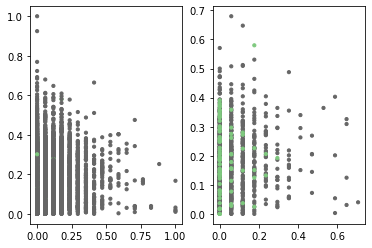

In [41]:
# set plot xticks
x = np.arange(0, len(y_over_synth_10), 1)
plt.xticks(x, x)
plt.subplot(1,2,1)
plt.scatter(X_train[:, 2], X_train[:, 3], c=y_train, s=10, cmap="Accent_r")
plt.subplot(1,2,2)
plt.scatter(X_under_synth_10[:, 2], X_under_synth_10[:, 3], c=y_under_synth_10, s=10, cmap="Accent_r")

## 4.4 Split the train data into train and validation data

In [42]:
X_over_synth_10_train,X_over_synth_10_val, y_over_synth_10_train,y_over_synth_10_val  = train_test_split(X_over_synth_10,y_over_synth_10,random_state=192,test_size=0.25)
X_over_synth_30_train,X_over_synth_30_val, y_over_synth_30_test,y_over_synth_30_val  = train_test_split(X_over_synth_30,y_over_synth_30,random_state=192,test_size=0.25)
X_over_synth_50_train,X_over_synth_50_val, y_over_synth_50_test,y_over_synth_50_val  = train_test_split(X_over_synth_50,y_over_synth_50,random_state=192,test_size=0.25)
X_under_synth_10_train,X_under_synth_10_val, y_under_synth_10_test,y_under_synth_10_val  = train_test_split(X_under_synth_10,y_under_synth_10,random_state=192,test_size=0.25)
X_under_synth_30_train,X_under_synth_30_val, y_under_synth_30_test,y_under_synth_30_val  = train_test_split(X_under_synth_30,y_under_synth_30,random_state=192,test_size=0.25)
X_under_synth_50_train,X_under_synth_50_val, y_under_synth_50_test,y_under_synth_50_val  = train_test_split(X_under_synth_50,y_under_synth_50,random_state=192,test_size=0.25)

In [43]:
print("The length of X_over_synth_10_train is:", len(X_over_synth_10_train))
print("The length of X_over_synth_10_val is:", len(X_over_synth_10_val))
print("The length of X_over_synth_30_train is:", len(X_over_synth_30_train))
print("The length of X_over_synth_30_val is:", len(X_over_synth_30_val))
print("The length of X_over_synth_50_train is:", len(X_over_synth_50_train))
print("The length of X_over_synth_50_val is:", len(X_over_synth_50_val))
print("The length of X_under_synth_10_train is:", len(X_under_synth_10_train))
print("The length of X_under_synth_10_val is:", len(X_under_synth_10_val))
print("The length of X_under_synth_30_train is:", len(X_under_synth_30_train))
print("The length of X_under_synth_30_val is:", len(X_under_synth_30_val))
print("The length of X_under_synth_50_train is:", len(X_under_synth_50_train))
print("The length of X_under_synth_50_val is:", len(X_under_synth_50_val))


The length of X_over_synth_10_train is: 7433
The length of X_over_synth_10_val is: 2478
The length of X_over_synth_30_train is: 10136
The length of X_over_synth_30_val is: 3379
The length of X_over_synth_50_train is: 13515
The length of X_over_synth_50_val is: 4505
The length of X_under_synth_10_train is: 709
The length of X_under_synth_10_val is: 237
The length of X_under_synth_30_train is: 193
The length of X_under_synth_30_val is: 65
The length of X_under_synth_50_train is: 129
The length of X_under_synth_50_val is: 43


## Task 5
### Question
 Create a new (deep) neural network and train it on your enhanced dataset. Use training and validation sets derived from the enhanced dataset to find a model with high accuracy. Evaluate your final model on a test set consisting only of original data. Again, record the accuracy and AUC. Briefly discuss the changes you would expect in the metrics and the actual changes you observe. Would you say that you are now doing better at identifying fraudulent claims?

### Principle
To simplify the problem, and save computational time, we will apply all the synthetic data to a very simple neural network, and then compare the performance of these dinstinct synthetic data.
The neural network structure is as follows:
1. Input layer
2. 2 Hiiden layers, in which the number of neurons in each layer is equal to input layer and 'relu' activation function is used.
3. No dropout layer
4. Output layer, with 'sigmoid' activation function.
5. Optimizer: AdamOptimizer

In [89]:
import keras_tuner as kt

In [50]:
def train_model(hp):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True) # set patience to 10 to accelerate the training
    number_units = hp.Int('number_units', min_value=20, max_value=80, step=20)
    dropout_rate = hp.Float('dropout_rate', min_value = 0.1, max_value=0.3) 
    optim_algo = hp.Choice('optimizer', values=['sgd','adam']) 
    learning_rate = hp.Float('learning_rate', min_value = 0.001, max_value=1, sampling='log') 
    number_layers = hp.Int('number_layers', min_value=1, max_value=3) # hidden layers
    activation = hp.Choice('activation', values=['relu','sigmoid'])
    whether_dropout = hp.Choice('whether_dropout', values=[True,False])

    if whether_dropout == True:
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(number_units, activation=activation)]*number_layers+[
            tf.keras.layers.Dense(1,activation='sigmoid')])
    else:
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(number_units, activation=activation)]*number_layers+[
            tf.keras.layers.Dense(1,activation='sigmoid')])

    if optim_algo== 'sgd':
        # Note that exploding gradients can be a big problem when running regressions, especially under SGD
        # Hence, we use "gradient clipping" with parameter alpha, which means that the gradients are manually kept between -1 and 1
        # This is of course another hyperparameter that we might tune!
        optimizer = tf.keras.optimizers.SGD(
            learning_rate=learning_rate, clipvalue=1)
    elif optim_algo == 'adam':
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=learning_rate)

    # random_seed = 192
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    return model


In [53]:
# Run the best model for X_over_synth_10_train
tuner = kt.Hyperband(train_model,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='logs_over_synth_10',
                     project_name='kt_tutorial_over_synth_10')
tuner.search(X_over_synth_10_train, y_over_synth_10_train, epochs=100, validation_data =(X_over_synth_10_val,y_over_synth_10_val))

Trial 255 Complete [00h 00m 26s]
val_loss: 0.04321100190281868

Best val_loss So Far: 0.022859999909996986
Total elapsed time: 00h 19m 57s
INFO:tensorflow:Oracle triggered exit


In [85]:
res_list = [] # FIXME
for X_train,y_train in zip([X_over_synth_10,X_over_synth_30,X_over_synth_50,X_under_synth_10,X_under_synth_30,X_under_synth_50], [y_over_synth_10,y_over_synth_30,y_over_synth_50,y_under_synth_10,y_under_synth_30,y_under_synth_50]):
    tm = TrainModel(X_train,y_train,early_stopping_cb=True,alpha=2)
    res = tm.run()
    res_list.append(res)

72/72 [==============================] - 0s 502us/step - loss: 0.6917 - accuracy: 0.1226


In [86]:
res_list

[{'loss': [0.12994028627872467, 0.9859340786933899],
  'accuracy': 0.985934065934066,
  'sensitivity': 0.038461538461538464,
  'roc': 0.8073502753360469},
 {'loss': [0.36349812150001526, 0.7947252988815308],
  'accuracy': 0.7947252747252748,
  'sensitivity': 0.6153846153846154,
  'roc': 0.8189451722132914},
 {'loss': [0.41826707124710083, 0.7542856931686401],
  'accuracy': 0.7542857142857143,
  'sensitivity': 0.7307692307692307,
  'roc': 0.8254437869822484},
 {'loss': [0.44103479385375977, 0.9885714054107666],
  'accuracy': 0.9885714285714285,
  'sensitivity': 0.0,
  'roc': 0.45786161370865686},
 {'loss': [0.6892063617706299, 0.9885714054107666],
  'accuracy': 0.9885714285714285,
  'sensitivity': 0.0,
  'roc': 0.5},
 {'loss': [0.6917232871055603, 0.12263736128807068],
  'accuracy': 0.12263736263736263,
  'sensitivity': 0.8076923076923077,
  'roc': 0.4451209084379383}]

## Task 6
### Question
Our second approach will be to use an autoencoder to learn what "normal" (non-fraudulent) data "looks like."

1. Prepare dataset for autoencoder

   - Using the original data, create a training set that contains only non fraudulent claims
   - As well as validation and test sets that contain non fraudulent and fraudulent claims. 
   - Make sure to spread fraudulent claims evenly across validation and test sets.

2. Create an autoencoder using TensorFlow

   - Ensure that the middle hidden layer has fewer neurons than your input features. 
   - Use training and validation sets to find a model that represents its input data well. In particular, you will want to predict your validation set observations. 
   - For each observation, you can measure the difference between the original observations and the predicted one, using, for example, the mean squared error of all features of the observation. 
   - Plot the errors for all your validation set observations in a histogram - in a good model, this error should be much higher for fraudulent claims than non-fraudulent ones.

3. Assess predictions of autoencoder created

   - Use your trained autoencoder to predict the test set and define the corresponding losses(?). 
   - Create a histogram of your test set claims, clearly marking fraudulent and non- fraudulent claims. 
   - Discuss how you could use this to decide whether a transaction is fraudulent or not. 
   - Can you also derive an AUC in this approach - if yes, how does it perform compared to the previous approaches?

In [38]:
df_autoencoder = df.copy()

In [43]:
# split dataset into non-fraud (normal) and fraud
normal_df = df_autoencoder[df_autoencoder.Fraud == 0]
fraud_df = df_autoencoder[df_autoencoder.Fraud == 1]
print(f'The length of normal_df: {len(normal_df)}')
print(f'The length of fraud_df: {len(fraud_df)}')

# variables for splitting data into train, val and test sets 
train_split = 0.8
test_split = 1 - train_split
normal_train_size = round(len(df_autoencoder) * train_split)
fraud_val_test_size = int(len(fraud_df) / 2)
normal_val_test_size = int(round(len(df_autoencoder) * test_split / 2) - fraud_val_test_size)
print(f'normal_train_size: {normal_train_size}')
print(f'fraud_val_test_size: {fraud_val_test_size}')
print(f'normal_val_test_size: {normal_val_test_size}\n')

# sample non-fraud data for train set
train_df = normal_df.sample(normal_train_size, random_state=0)
normal_df = normal_df[~normal_df.isin(train_df)].dropna()
print(f'len(train_df): {len(train_df)}')
print(f'len(normal_df) excluding data in train_df: {len(normal_df)}\n')

# sample non-fraud data for val and test sets
val_df = normal_df.sample(normal_val_test_size, random_state=0)
test_df = normal_df[~normal_df.isin(val_df)].dropna()
print(f'len(val_df): {len(val_df)}')
print(f'len(test_df): {len(test_df)}\n')

# check if all normal data is in the train, val and test sets
normal_df = df_autoencoder[df_autoencoder.Fraud == 0]
test = pd.concat([train_df, val_df, test_df]).isin(normal_df)
print(f'len(test[test.LossDate == False]) = {len(test[test.LossDate == False])}\n')

# sample fraud data for val and test sets
val_df = val_df.append(fraud_df.sample(fraud_val_test_size, random_state=0))
test_df = test_df.append(fraud_df[~fraud_df.isin(val_df)].dropna())
print(f'len(val_df): {len(val_df)}')
print(f'len(test_df): {len(test_df)}\n')

print(f'Check if len(train_df) + len(val_df) + len(test_df) == len(df_autoencoder): {len(train_df) + len(val_df) + len(test_df) == len(df_autoencoder)}')

The length of normal_df: 11259
The length of fraud_df: 112
normal_train_size: 9097
fraud_val_test_size: 56
normal_val_test_size: 1081

len(train_df): 9097
len(normal_df) excluding data in train_df: 2162

len(val_df): 1081
len(test_df): 1081

len(test[test.LossDate == False]) = 0

len(val_df): 1137
len(test_df): 1137

Check if len(train_df) + len(val_df) + len(test_df) == len(df_autoencoder): True


/var/folders/3d/_kfrpmln4vl2vz6_7j1h6byh0000gn/T/ipykernel_78650/3527323588.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  val_df = val_df.append(fraud_df.sample(fraud_val_test_size, random_state=0))
/var/folders/3d/_kfrpmln4vl2vz6_7j1h6byh0000gn/T/ipykernel_78650/3527323588.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(fraud_df[~fraud_df.isin(val_df)].dropna())


In [44]:
y_train = train_df[['Fraud']].to_numpy()
y_val = val_df[['Fraud']].to_numpy()
y_test = test_df[['Fraud']].to_numpy()

X_train = train_df.drop(['Fraud'], axis=1)
X_val = val_df.drop(['Fraud'], axis=1)
X_test = test_df.drop(['Fraud'], axis=1)

train_col_names = list(X_train.columns)+['df_key']

In [45]:
# Fit the MinMaxScaler
scaler = MinMaxScaler()

X_train.loc[:,'df_key'] = 1
X_val.loc[:,'df_key'] = 0
X_test.loc[:,'df_key'] = 0
X_train_val = pd.concat([X_train, X_val])
# X_df_key = X_train_val[['df_key']]
# X_train_val = X_train_val.drop(['df_key'], axis=1)

X_train_val = pd.DataFrame(scaler.fit_transform(X_train_val), columns=train_col_names)
X_test = pd.DataFrame(scaler.transform(X_test), columns=train_col_names)
X_test = X_test.drop(['df_key'], axis=1)
X_train = X_train_val[X_train_val.df_key == 1].drop(['df_key'], axis=1)
X_val = X_train_val[X_train_val.df_key == 0].drop(['df_key'], axis=1)

print(f'check if len(X_train) + len(X_val) + len(X_test) == len(df_autoencoder): {len(X_train) + len(X_val) + len(X_test) == len(df_autoencoder)}')

X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()

check if len(X_train) + len(X_val) + len(X_test) == len(df_autoencoder): True


In [46]:
reg_param = 0.01
regularizer = tf.keras.regularizers.l2(reg_param)
input_dim = X_train.shape[1]
encoder_decoder_dim = 60
bottleneck_dim = 30

In [47]:
encoder = tf.keras.Sequential([
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(encoder_decoder_dim, activation="relu"),
    tf.keras.layers.Dense(encoder_decoder_dim, activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(bottleneck_dim, activation="relu", kernel_regularizer=regularizer)
])

decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(encoder_decoder_dim, activation="relu"),
    tf.keras.layers.Dense(encoder_decoder_dim, activation="relu"),
    tf.keras.layers.Dense(input_dim, activation="sigmoid")
])

autoencoder = tf.keras.Sequential([
    encoder,
    decoder
])

In [54]:
# Use tunner to find the best parameters
def train_model(hp):
    reg_param = hp.Float('dropout_rate', min_value = 0.01, max_value=0.3, sampling='log') 
    number_units_layers = hp.Int('number_units', min_value=30, max_value = 60, step = 15)
    number_units_bottleneck = hp.Int('number_units_bottleneck', min_value=15, max_value = 30, step = 5)
    dropout_rate = hp.Float('dropout_rate', min_value = 0.1, max_value=0.3) 
    number_layers = hp.Int('number_layers', min_value=1, max_value=3) # hidden layers
    whether_dropout = hp.Choice('whether_dropout', values=[True,False])
    whether_regularizer = hp.Choice('whether_regularizer', values=[True,False])

    regularizer = tf.keras.regularizers.l2(reg_param*whether_regularizer) # if whether_regularizer == True, then reg_param is used or it will be 0
    if whether_dropout == True:
        encoder = tf.keras.models.Sequential([
            tf.keras.layers.Dense(number_units_layers, activation="relu")]*number_layers+[
            tf.keras.layers.Dropout(dropout_rate), # dropout before the bottleneck layer
            tf.keras.layers.Dense(number_units_bottleneck,activation='sigmoid', kernel_regularizer=regularizer)])
    else:
        encoder = tf.keras.models.Sequential([
            tf.keras.layers.Dense(number_units_layers, activation="relu")]*number_layers+[
            tf.keras.layers.Dense(input_dim,activation='sigmoid')])
    decoder = tf.keras.models.Sequential([
            tf.keras.layers.Dense(number_units_layers, activation="relu")]*number_layers+[
            tf.keras.layers.Dense(input_dim, activation="sigmoid")])
    autoencoder = tf.keras.models.Sequential([encoder, decoder])

    optimizer
    # random_seed = 192
    autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')
    return autoencoder


In [55]:
# Run the best model for X_over_synth_10_train
tuner = kt.Hyperband(train_model,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='logs_autoencoder_tuner',
                     project_name='kt_autoencoder_tuner')
tuner.search(X_train, X_train, epochs=100, validation_data =(X_val,X_val))

Trial 30 Complete [00h 00m 11s]
val_loss: 0.0357041172683239

Best val_loss So Far: 0.004762224853038788
Total elapsed time: 00h 03m 01s
INFO:tensorflow:Oracle triggered exit


In [58]:
best_hps = tuner.get_best_hyperparameters()[0]
best_model = tuner.hypermodel.build(best_hps)

In [59]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True) # set patience to 10 to accelerate the training
autoencoder_log = best_model.fit(x=X_train, y=X_train, epochs=200, validation_data=(X_val, X_val),callbacks=[early_stopping_cb])

Epoch 1/200
285/285 [==============================] - 1s 1ms/step - loss: 0.0357 - accuracy: 0.0258 - val_loss: 0.0194 - val_accuracy: 0.0290
Epoch 2/200
285/285 [==============================] - 0s 1ms/step - loss: 0.0157 - accuracy: 0.0288 - val_loss: 0.0124 - val_accuracy: 0.0361
Epoch 3/200
285/285 [==============================] - 0s 1ms/step - loss: 0.0111 - accuracy: 0.0306 - val_loss: 0.0095 - val_accuracy: 0.0369
Epoch 4/200
285/285 [==============================] - 0s 1ms/step - loss: 0.0089 - accuracy: 0.0409 - val_loss: 0.0080 - val_accuracy: 0.0405
Epoch 5/200
285/285 [==============================] - 0s 1ms/step - loss: 0.0073 - accuracy: 0.0335 - val_loss: 0.0066 - val_accuracy: 0.0493
Epoch 6/200
285/285 [==============================] - 0s 1ms/step - loss: 0.0060 - accuracy: 0.0289 - val_loss: 0.0058 - val_accuracy: 0.0343
Epoch 7/200
285/285 [==============================] - 0s 971us/step - loss: 0.0052 - accuracy: 0.0193 - val_loss: 0.0052 - val_accuracy: 0.01

In [49]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [50]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True) # set patience to 10 to accelerate the training
autoencoder_log = autoencoder.fit(x=X_train, y=X_train, epochs=200, validation_data=(X_val, X_val),callbacks=[early_stopping_cb])

Epoch 1/200
285/285 [==============================] - 1s 1ms/step - loss: 0.1665 - val_loss: 0.0379
Epoch 2/200
285/285 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0256
Epoch 3/200
285/285 [==============================] - 0s 950us/step - loss: 0.0250 - val_loss: 0.0233
Epoch 4/200
285/285 [==============================] - 0s 945us/step - loss: 0.0221 - val_loss: 0.0205
Epoch 5/200
285/285 [==============================] - 0s 939us/step - loss: 0.0202 - val_loss: 0.0189
Epoch 6/200
285/285 [==============================] - 0s 940us/step - loss: 0.0185 - val_loss: 0.0170
Epoch 7/200
285/285 [==============================] - 0s 949us/step - loss: 0.0171 - val_loss: 0.0160
Epoch 8/200
285/285 [==============================] - 0s 1ms/step - loss: 0.0160 - val_loss: 0.0150
Epoch 9/200
285/285 [==============================] - 0s 1ms/step - loss: 0.0153 - val_loss: 0.0148
Epoch 10/200
285/285 [==============================] - 0s 1ms/step - loss: 0.014

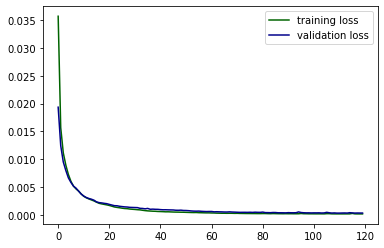

In [60]:
def create_plot(log):
    # plt.plot(log.history['accuracy'],label = "training accuracy",color='green')
    plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
    # plt.plot(log.history['val_accuracy'], label = "validation accuracy",color='grey')
    plt.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    plt.legend()
    plt.show()
    
create_plot(autoencoder_log)

In [61]:
X_pred = autoencoder.predict(X_val)
mse = np.mean(np.power(X_val.flatten() - X_pred.flatten(), 2))
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_val.flatten()})
error_df

,Reconstruction_error,True_class
0,0.005409,0.0
1,0.005409,0.0
2,0.005409,0.0
3,0.005409,0.0
4,0.005409,0.0
...,...,...
1132,0.005409,1.0
1133,0.005409,1.0
1134,0.005409,1.0
1135,0.005409,1.0


In [62]:
y_val

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]])

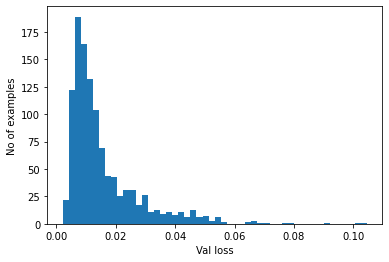

In [63]:
reconstructions = autoencoder.predict(X_val)
val_loss = tf.keras.losses.mae(reconstructions, X_val)
# train_loss = tf.keras.losses.MeanSquaredError(reconstructions, X_val)

plt.hist(val_loss[None,:], bins=50)
plt.xlabel("Val loss")
plt.ylabel("No of examples")
plt.show()

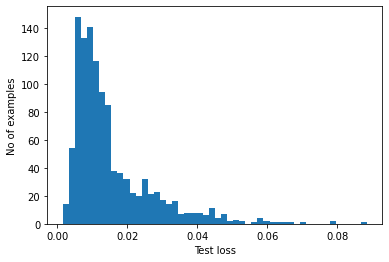

In [66]:
reconstructions = autoencoder.predict(X_test)
test_loss = tf.keras.losses.mae(reconstructions, X_test)
# train_loss = tf.keras.losses.MeanSquaredError(reconstructions, X_val)

plt.hist(test_loss[None,:], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [67]:
threshold = np.mean(val_loss) + np.std(val_loss)
print("Threshold: ", threshold)

Threshold:  0.02815029799949451


<AxesSubplot:>

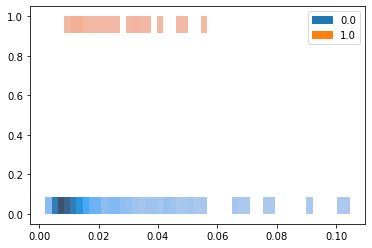

In [68]:
import seaborn as sns

sns.histplot(x=val_loss,y=y_val.flatten(),hue=y_val.flatten())

In [69]:
# change tensorflow to numpy
roc_auc_score(y_val.flatten(), val_loss)

0.7441687590855028

In [92]:
# the cost function
from sklearn.metrics import confusion_matrix
def calculate_cost(fn,fp):
    return 100*fn+fp

cost_lost = {}
for i in np.linspace(0,0.1,100):
    pred_y = np.where(val_loss > i, 1, 0)
    cm = confusion_matrix(y_val.flatten(), pred_y)
    fn,fp = cm[1][0],cm[0][1]
    # cost_lost["Threshold: "+str(i)] = calculate_cost(fn,fp)
    cost_lost[i] = calculate_cost(fn,fp)

optimal_threshold = min(cost_lost, key=cost_lost.get)

In [93]:
pred_y = np.where(val_loss > optimal_threshold, 1, 0)
cm = confusion_matrix(y_val.flatten(), pred_y)
print(cm[1,1])

56


In [94]:
cm

array([[404, 677],
       [  0,  56]])